# Relax Inc. Take-Home Challenge


### Data
The data is available as two attached CSV files:
    - takehome_user_engagement.csv
    - takehome_users.csv
> The data has the following two tables:
>
>     1] A user table ("takehome_users") with data on 12,000 users who signed up for the
>        product in the last two years. This table includes:
>
>             ● name: the user's name
            ● object_id: the user's id
            ● email: email address
            ● creation_source: how their account was created. This takes on one
              of 5 values:
                ○ PERSONAL_PROJECTS: invited to join another user's
                  personal workspace
                ○ GUEST_INVITE: invited to an organization as a guest
                  (limited permissions)
                ○ ORG_INVITE: invited to an organization (as a full member)
                ○ SIGNUP: signed up via the website
                ○ SIGNUP_GOOGLE_AUTH: signed up using Google
                  Authentication (using a Google email account for their login
                  id)
            ● creation_time: when they created their account
            ● last_session_creation_time: unix timestamp of last login
            ● opted_in_to_mailing_list: whether they have opted into receiving
              marketing emails
            ● enabled_for_marketing_drip: whether they are on the regular
              marketing email drip
            ● org_id: the organization (group of users) they belong to
            ● invited_by_user_id: which user invited them to join (if applicable).
>
> 2] A usage summary table ("takehome_user_engagement") that has a row for each day
that a user logged into the product.
>
>


 ### Task

 Defining an **"adopted user"** as a user who has logged into the product on **three separate days** in at least one seven day period, ***identify which factors predict future user adoption.***

### Imports:

In [1]:
import pandas as pd
import numpy as np
import datetime
from pandas.core import resample as rp
import warnings
  
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score,\
precision_score, recall_score, f1_score


### Loading Data:

In [2]:
#users data
users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
print("number of users: ",len(users))
users.rename(columns = {"object_id":"user_id"}, inplace = True)
print(users.info())
users.head()

number of users:  12000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
#engagement data
logs = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)
print(logs.info())
logs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Handling Missing Values

In [4]:
users.isnull().sum().sort_values(ascending=False) # two types of missing values here

invited_by_user_id            5583
last_session_creation_time    3177
user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
dtype: int64

In [5]:
logs.isnull().sum()  # no missing values in log file

time_stamp    0
user_id       0
visited       0
dtype: int64

We have 5583 users that hasn't been directly invited by another user (46.5% of all users).

We also have 3177 users without last session created (26.5% of users)

In [6]:
len(users['user_id'].unique())-len(logs['user_id'].unique())   #missing sessions are not in log file as well

3177

The 3177 users with missing last sessions are not loged in and are not in the log file as well. so about 

In [7]:
users.invited_by_user_id.fillna(-1, inplace = True)
users.invited_by_user_id=users.invited_by_user_id.astype(int)

### Finding "adopted" users from log file:

In [8]:
#"adopted user": logged in on three separate days in at least one seven day period
logs['time_stamp'] = pd.to_datetime(logs.time_stamp)
logs['Date'] = pd.to_datetime(logs["time_stamp"]).dt.date
# removing multiple logs on the same day:
grouped=logs.groupby(['user_id','Date']).agg(visited = ('visited','max')).reset_index()  
print(len(grouped))
logs

207917


,time_stamp,user_id,visited,Date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25
...,...,...,...,...
207912,2013-09-06 06:14:15,11996,1,2013-09-06
207913,2013-01-15 18:28:37,11997,1,2013-01-15
207914,2014-04-27 12:45:16,11998,1,2014-04-27
207915,2012-06-02 11:55:59,11999,1,2012-06-02


##### P.S. no one had logged twice in a day!!! 

In [9]:
#logs.groupby('user_id').rolling('7D', on='time_stamp').visited.sum()
#logs.groupby('user_id').visited.sum()
grouped['Date'] = pd.to_datetime(grouped.Date)
grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  207917 non-null  int64         
 1   Date     207917 non-null  datetime64[ns]
 2   visited  207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [10]:
grouped['TwoVisitsBack'] = grouped.groupby('user_id')['Date'].shift(2)
grouped.head(20)

,user_id,Date,visited,TwoVisitsBack
0,1,2014-04-22,1,NaT
1,2,2013-11-15,1,NaT
2,2,2013-11-29,1,NaT
3,2,2013-12-09,1,2013-11-15
4,2,2013-12-25,1,2013-11-29
5,2,2013-12-31,1,2013-12-09
6,2,2014-01-08,1,2013-12-25
7,2,2014-02-03,1,2013-12-31
8,2,2014-02-08,1,2014-01-08
9,2,2014-02-09,1,2014-02-03


In [11]:
grouped['Last3VisitSpan'] = grouped.Date - grouped.TwoVisitsBack
grouped.head(16).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
user_id,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3
Date,2014-04-22 00:00:00,2013-11-15 00:00:00,2013-11-29 00:00:00,2013-12-09 00:00:00,2013-12-25 00:00:00,2013-12-31 00:00:00,2014-01-08 00:00:00,2014-02-03 00:00:00,2014-02-08 00:00:00,2014-02-09 00:00:00,2014-02-13 00:00:00,2014-02-16 00:00:00,2014-03-09 00:00:00,2014-03-13 00:00:00,2014-03-31 00:00:00,2013-03-19 00:00:00
visited,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
TwoVisitsBack,NaT,NaT,NaT,2013-11-15 00:00:00,2013-11-29 00:00:00,2013-12-09 00:00:00,2013-12-25 00:00:00,2013-12-31 00:00:00,2014-01-08 00:00:00,2014-02-03 00:00:00,2014-02-08 00:00:00,2014-02-09 00:00:00,2014-02-13 00:00:00,2014-02-16 00:00:00,2014-03-09 00:00:00,NaT
Last3VisitSpan,NaT,NaT,NaT,24 days 00:00:00,26 days 00:00:00,22 days 00:00:00,14 days 00:00:00,34 days 00:00:00,31 days 00:00:00,6 days 00:00:00,5 days 00:00:00,7 days 00:00:00,24 days 00:00:00,25 days 00:00:00,22 days 00:00:00,NaT


In [12]:
# user_id of the people who had logged into the product for 3 separate days in at least 1 seven-day period
ids = grouped[(grouped.Last3VisitSpan.dt.days>=1) & (grouped.Last3VisitSpan.dt.days<=7)].user_id.unique()
print(f'number of adopted users: {len(ids)} which is {len(ids)/len(users)*100}% of the users' )
ids

number of adopted users: 1656 which is 13.8% of the users


array([    2,    10,    20, ..., 11969, 11975, 11988])

In [13]:
cols = users.columns.tolist()
print(cols)
cols = ['user_id', 'adopted','creation_time', 'name', 'email', 'creation_source', 'last_session_creation_time', 
        'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']

users['adopted'] = users['user_id'].apply(lambda x: 1 if x in ids else 0)
users=users[cols]
print(users.info())

users.head(3).T

['user_id', 'creation_time', 'name', 'email', 'creation_source', 'last_session_creation_time', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   adopted                     12000 non-null  int64  
 2   creation_time               12000 non-null  object 
 3   name                        12000 non-null  object 
 4   email                       12000 non-null  object 
 5   creation_source             12000 non-null  object 
 6   last_session_creation_time  8823 non-null   float64
 7   opted_in_to_mailing_list    12000 non-null  int64  
 8   enabled_for_marketing_drip  12000 non-null  int64  
 9   org_id                      12000 non-null  int64  
 10  invited_by_user_i

,0,1,2
user_id,1,2,3
adopted,0,1,0
creation_time,2014-04-22 03:53:30,2013-11-15 03:45:04,2013-03-19 23:14:52
name,Clausen August,Poole Matthew,Bottrill Mitchell
email,AugustCClausen@yahoo.com,MatthewPoole@gustr.com,MitchellBottrill@gustr.com
creation_source,GUEST_INVITE,ORG_INVITE,ORG_INVITE
last_session_creation_time,1398138810.0,1396237504.0,1363734892.0
opted_in_to_mailing_list,1,0,0
enabled_for_marketing_drip,0,0,0
org_id,11,1,94


### Feature Engineering:
#### Number of users invited

In [14]:
g=users.groupby('invited_by_user_id').agg(number_of_users_invited=('invited_by_user_id','size')).reset_index()
g=g.rename(columns = {'invited_by_user_id':'user_id'})
g.T

,0,1,2,3,4,5,6,7,8,9,...,2555,2556,2557,2558,2559,2560,2561,2562,2563,2564
user_id,-1,3,7,10,21,23,29,37,47,49,...,11966,11972,11973,11974,11978,11981,11986,11994,11997,11999
number_of_users_invited,5583,1,5,1,1,3,1,5,6,1,...,6,1,4,1,1,1,1,7,1,7


In [15]:
#users.merge(g,how='inner',on='user_id')
users = pd.merge(users,g,how="left",on='user_id')
users.number_of_users_invited.fillna(0, inplace = True)
users.number_of_users_invited=users.number_of_users_invited.astype(int)
users.head(10)

,user_id,adopted,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,number_of_users_invited
0,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,0
1,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,0
2,3,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,1
3,4,0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,0
4,5,0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,0
5,6,0,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241,0
6,7,0,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,-1,5
7,8,0,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,-1,0
8,9,0,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,-1,0
9,10,1,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143,1


In [16]:
#### For this we need to match the users index with useres_id
#users.loc[users.invited_by_user_id==-1,"invited_by_user_id"]=99999
#users.invited_by_user_id
#users.invited_by_user_id=users.invited_by_user_id.astype(int)
#users['invited_count'] = users.groupby('invited_by_user_id').size()
#users

#### Email Provider:

In [17]:
users['email_provider'] = users['email'].str.split('@').str[1].str.split('.').str[0]
users['email_provider'].value_counts().head(8)
#df['Label'] = df['Label'].map({'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9})

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
gustr         1179
hotmail       1165
rerwl            2
oqpze            2
Name: email_provider, dtype: int64

In [18]:
#counts = df['Jobrol'].value_counts()
#others = counts[counts == 1].index

#df['Label'] = df['Label'].map({'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9})
users['email_provider'] = users['email_provider'].map({x[0]: x[0] if x[1] > 100 else 'other' for x in dict(users['email_provider'].value_counts()).items()})
users['email_provider'].value_counts()


gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email_provider, dtype: int64

#### Duration (First and last appearance)

In [19]:
users['last_session_date']=pd.to_datetime(users['last_session_creation_time'], unit='s').dt.date
users.creation_time = pd.to_datetime(users.creation_time)
users['creation_date']=users.creation_time.dt.date
users['duration'] = users['last_session_date']-users['creation_date']
users.duration.fillna("0 days", inplace = True)
users['duration']=users['duration'].apply(lambda x : str(x).split(' ')[0])
users = users.astype({"duration": int})

#users2 = (users.groupby(['user_id'])['Timestamp']
#         .agg(lambda x: x.iat[-1] - x.iat[0])
#         .reset_index(name='diff'))
#df.sum(axis=1)
users.head(24)

,user_id,adopted,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,number_of_users_invited,email_provider,last_session_date,creation_date,duration
0,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,0,yahoo,2014-04-22,2014-04-22,0
1,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,0,gustr,2014-03-31,2013-11-15,136
2,3,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,1,gustr,2013-03-19,2013-03-19,0
3,4,0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,0,yahoo,2013-05-22,2013-05-21,1
4,5,0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,0,yahoo,2013-01-22,2013-01-17,5
5,6,0,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241,0,yahoo,2013-12-19,2013-12-17,2
6,7,0,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,-1,5,jourrapide,2012-12-20,2012-12-16,4
7,8,0,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,-1,0,yahoo,NaT,2013-07-31,0
8,9,0,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,-1,0,hotmail,NaT,2013-11-05,0
9,10,1,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143,1,gustr,2014-06-03,2013-01-16,503


In [20]:
#Print Error


In [21]:
f=users[['user_id','creation_time','last_session_date','adopted']]

f['cr_date'] = f['creation_time'].dt.date
f['cr_day'] = f['creation_time'].dt.dayofweek #mon=0 Fri=4
f['cr_hour'] = f['creation_time'].dt.hour
f['duration'] = f['last_session_date']-f['cr_date']
f.duration.fillna("0 days", inplace = True)
f['duration']=f['duration'].apply(lambda x : str(x).split(' ')[0])
f = f.astype({"duration": int})
f.head(24)
#f = f.astype({"duration": int, "adopted": object})


,user_id,creation_time,last_session_date,adopted,cr_date,cr_day,cr_hour,duration
0,1,2014-04-22 03:53:30,2014-04-22,0,2014-04-22,1,3,0
1,2,2013-11-15 03:45:04,2014-03-31,1,2013-11-15,4,3,136
2,3,2013-03-19 23:14:52,2013-03-19,0,2013-03-19,1,23,0
3,4,2013-05-21 08:09:28,2013-05-22,0,2013-05-21,1,8,1
4,5,2013-01-17 10:14:20,2013-01-22,0,2013-01-17,3,10,5
5,6,2013-12-17 03:37:06,2013-12-19,0,2013-12-17,1,3,2
6,7,2012-12-16 13:24:32,2012-12-20,0,2012-12-16,6,13,4
7,8,2013-07-31 05:34:02,NaT,0,2013-07-31,2,5,0
8,9,2013-11-05 04:04:24,NaT,0,2013-11-05,1,4,0
9,10,2013-01-16 22:08:03,2014-06-03,1,2013-01-16,2,22,503


(0.0, 24.0)

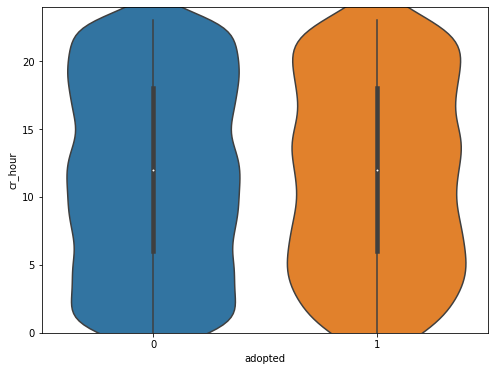

In [22]:
### Creation hour has no significant relation with being adopted
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.violinplot(y="cr_hour", 
                x="adopted", 
                data=f)
plt.ylim(0,24)
#sns.swarmplot(y="cr_hour", 
#                x="adopted", 
#                data=f, 
#                   color="white", edgecolor="gray")

#sns.violin(f.cr_hour)
#users.head()

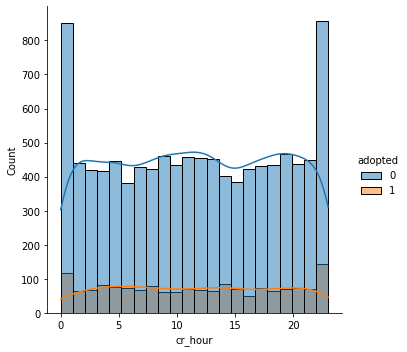

In [23]:
sns.displot(data=f, x="cr_hour", hue='adopted', kde=True)

In [24]:
f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            12000 non-null  int64         
 1   creation_time      12000 non-null  datetime64[ns]
 2   last_session_date  8823 non-null   object        
 3   adopted            12000 non-null  int64         
 4   cr_date            12000 non-null  object        
 5   cr_day             12000 non-null  int64         
 6   cr_hour            12000 non-null  int64         
 7   duration           12000 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 1.1+ MB


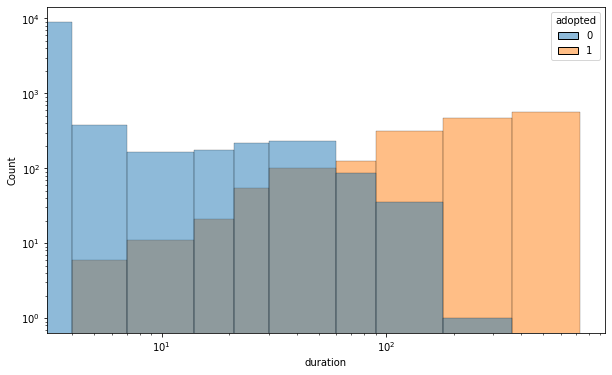

In [25]:
## adopted users has significantly used the product for longer time period
plt.figure(figsize=(10,6))
labels = ['0',"4","1st week","2nd Week","3rd Week", "1st Month","2nd Month","3rd Month","half year","1st year",'max']
bins=[0,4,7,14,21,30,60,90,180,365,max(f.duration)]
sns.histplot(data=f,x='duration',hue='adopted',bins=bins, label=labels)
plt.xticks(ticks=bins,labels=labels)
plt.yscale('log')
plt.xscale('log')

<AxesSubplot:ylabel='duration'>

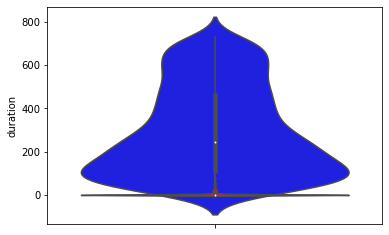

In [26]:
sns.violinplot(data=f[f.adopted==1], y="duration", kde=False, color='blue')
sns.violinplot(data=f[f.adopted==0], y="duration", kde=True, color='red')

#plt.yscale('log')

In [45]:
#sns.boxplot(y=f[f.adopted==1].duration)
#sns.displot(data=f[f.adopted==1], x="duration")
#sns.displot(data=f[f.adopted==0], x="duration")
#sns.displot(data=f[f.adopted==1], x="duration",alpha=0.2)#,hue='adopted')
#sns.distplot(data=f[f.adopted==0], x="duration",alpha=0.2)#,hue='adopted')
#plt.xlim(10,60)
#plt.xlim(0,700)
#plt.yscale('log')


In [28]:
print(f'{round(f[(f.adopted==0) & (f.duration >30)].user_id.count()/f[(f.adopted==0)].user_id.count()*100,2)} % of non-adopted users stayed for 30 days or longer')
print(f'{round(f[(f.adopted==1) & (f.duration <30)].user_id.count()/f[(f.adopted==1)].user_id.count()*100,2)} % of adopted users stayed for 30 days or less')

3.39 % of non-adopted users stayed for 30 days or longer
5.56 % of adopted users stayed for 30 days or less


In [29]:
users[users.last_session_creation_time.isnull()].groupby('creation_source').size()

creation_source
GUEST_INVITE          575
ORG_INVITE           1066
PERSONAL_PROJECTS    1347
SIGNUP                189
dtype: int64

### Logs in First month:

In [30]:
logs.head()

,time_stamp,user_id,visited,Date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [31]:
users.head()

,user_id,adopted,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,number_of_users_invited,email_provider,last_session_date,creation_date,duration
0,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,0,yahoo,2014-04-22,2014-04-22,0
1,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,0,gustr,2014-03-31,2013-11-15,136
2,3,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,1,gustr,2013-03-19,2013-03-19,0
3,4,0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,0,yahoo,2013-05-22,2013-05-21,1
4,5,0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,0,yahoo,2013-01-22,2013-01-17,5


In [32]:
df=logs.merge(users[['user_id','adopted','creation_date']],on='user_id', how='inner')
df['onemonthdate']=df['creation_date']+pd.DateOffset(days=30)
df1=df[df.onemonthdate>df.Date].groupby('user_id').agg(FirstMonthLogs=('visited','sum')).reset_index()
df1.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
user_id,1,2,3,4,5,6,7,10,11,13,14,17,19,20,21,22,23,24,25,27
FirstMonthLogs,1,3,1,1,1,1,1,6,1,1,1,1,2,3,1,1,1,1,2,1


In [33]:
users=users.merge(df1,on='user_id', how='left')
users.FirstMonthLogs.fillna(0, inplace = True)
users = users.astype({"FirstMonthLogs": int})
users.head(24)

,user_id,adopted,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,number_of_users_invited,email_provider,last_session_date,creation_date,duration,FirstMonthLogs
0,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,0,yahoo,2014-04-22,2014-04-22,0,1
1,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,0,gustr,2014-03-31,2013-11-15,136,3
2,3,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,1,gustr,2013-03-19,2013-03-19,0,1
3,4,0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,0,yahoo,2013-05-22,2013-05-21,1,1
4,5,0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,0,yahoo,2013-01-22,2013-01-17,5,1
5,6,0,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241,0,yahoo,2013-12-19,2013-12-17,2,1
6,7,0,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,-1,5,jourrapide,2012-12-20,2012-12-16,4,1
7,8,0,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,-1,0,yahoo,NaT,2013-07-31,0,0
8,9,0,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,-1,0,hotmail,NaT,2013-11-05,0,0
9,10,1,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143,1,gustr,2014-06-03,2013-01-16,503,6


In [34]:
from datetime import datetime
print(max(users.last_session_date),max(users.creation_date))
users['creation_date'] = pd.to_datetime(users.creation_date)
lt=datetime.strptime("2014/05/06", "%Y/%m/%d")
users[users['creation_date']>=lt].user_id
#users[['creation_date']].info()

2014-06-06 2014-05-30


37          38
39          40
43          44
60          61
69          70
         ...  
11907    11908
11935    11936
11937    11938
11939    11940
11950    11951
Name: user_id, Length: 844, dtype: int64

In [35]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   adopted                     12000 non-null  int64         
 2   creation_time               12000 non-null  datetime64[ns]
 3   name                        12000 non-null  object        
 4   email                       12000 non-null  object        
 5   creation_source             12000 non-null  object        
 6   last_session_creation_time  8823 non-null   float64       
 7   opted_in_to_mailing_list    12000 non-null  int64         
 8   enabled_for_marketing_drip  12000 non-null  int64         
 9   org_id                      12000 non-null  int64         
 10  invited_by_user_id          12000 non-null  int64         
 11  number_of_users_invited     12000 non-null  int64     

In [36]:
users.org_id.nunique()

417

In [37]:
#dropping unhelpful columns for feature importance:
users.drop(['user_id', 'name', 'email', 'creation_time','last_session_creation_time','last_session_date',
           'creation_date'], axis = 1, inplace = True)
users.sample(10)

,adopted,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,number_of_users_invited,email_provider,duration,FirstMonthLogs
7260,0,SIGNUP_GOOGLE_AUTH,0,1,167,-1,0,gmail,18,3
5548,0,PERSONAL_PROJECTS,0,0,200,-1,0,cuvox,0,0
6090,0,SIGNUP,1,1,275,-1,0,gmail,2,1
2215,0,PERSONAL_PROJECTS,1,1,96,-1,0,other,0,0
3891,0,ORG_INVITE,0,0,153,3935,0,gustr,0,0
1412,0,ORG_INVITE,1,0,358,906,0,yahoo,0,0
8116,0,GUEST_INVITE,0,0,12,2423,0,cuvox,1,1
8421,0,ORG_INVITE,1,1,25,3944,0,jourrapide,0,0
243,0,ORG_INVITE,0,0,154,7202,0,yahoo,2,1
3347,0,GUEST_INVITE,0,0,4,3789,0,gmail,0,0


In [38]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   adopted                     12000 non-null  int64 
 1   creation_source             12000 non-null  object
 2   opted_in_to_mailing_list    12000 non-null  int64 
 3   enabled_for_marketing_drip  12000 non-null  int64 
 4   org_id                      12000 non-null  int64 
 5   invited_by_user_id          12000 non-null  int64 
 6   number_of_users_invited     12000 non-null  int64 
 7   email_provider              12000 non-null  object
 8   duration                    12000 non-null  int64 
 9   FirstMonthLogs              12000 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 1.0+ MB


In [39]:
users = pd.get_dummies(users, columns=['creation_source','email_provider'])
print(users.shape)
users.head()


(12000, 20)


,adopted,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,number_of_users_invited,duration,FirstMonthLogs,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_provider_cuvox,email_provider_gmail,email_provider_gustr,email_provider_hotmail,email_provider_jourrapide,email_provider_other,email_provider_yahoo
0,0,1,0,11,10803,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,316,0,136,3,0,1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,94,1525,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,5151,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,193,5240,0,5,1,1,0,0,0,0,0,0,0,0,0,0,1


In [40]:
users.corr()['adopted']

adopted                               1.000000
opted_in_to_mailing_list              0.008838
enabled_for_marketing_drip            0.006578
org_id                                0.066995
invited_by_user_id                    0.021966
number_of_users_invited               0.044453
duration                              0.788421
FirstMonthLogs                        0.639403
creation_source_GUEST_INVITE          0.044317
creation_source_ORG_INVITE           -0.006592
creation_source_PERSONAL_PROJECTS    -0.075717
creation_source_SIGNUP                0.008920
creation_source_SIGNUP_GOOGLE_AUTH    0.036198
email_provider_cuvox                 -0.017606
email_provider_gmail                  0.034611
email_provider_gustr                 -0.010311
email_provider_hotmail                0.036095
email_provider_jourrapide            -0.002950
email_provider_other                 -0.000541
email_provider_yahoo                 -0.042389
Name: adopted, dtype: float64

In [41]:
def cv_optimize(model, parameters, Xtrain, ytrain, n_folds = 5):
    """
    Cross validation. Function to hypertune the model "model" with the input paramete distribution using
    "parameters" on the training data.
    The output will be the best estimator whose average score on all folds will be best. 
    """
    clf = GridSearchCV(model, param_grid = parameters, cv = n_folds, scoring = 'accuracy')
    t0 = time.time()
    clf.fit(Xtrain, ytrain)
    time_fit = time.time() - t0 
    print('\n\n\n=============================',type(model).__name__,'=================================\n')
    print("It takes %.3f seconds for tuning " % (time_fit))
    print("BEST PARAMS", clf.best_params_)
    best = clf.best_estimator_
    return best
    
def do_classify(model, parameters, df, targetname, scale = True, cols_to_transform = 'numeric', 
                featurenames = 'all', train_size = 0.8):
      
    # Creating the X and y variables for our model
    if featurenames == 'all':
        X = df.drop([targetname], axis = 1)
    else:
        X = df[featurenames]
        
    y = df[targetname]
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = train_size)

    model = cv_optimize(model, parameters, Xtrain, ytrain)
    t0 = time.time()
    model = model.fit(Xtrain, ytrain)
    time_fit = time.time() - t0 
    print("It takes %.3f seconds for fitting" % (time_fit))
    training_accuracy = model.score(Xtrain, ytrain)
    test_accuracy = model.score(Xtest, ytest)
    precision = precision_score(ytest, model.predict(Xtest))
    recall = recall_score(ytest, model.predict(Xtest))
    AUC = roc_auc_score(ytest, model.predict_proba(Xtest)[:,1])
            
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    print("Precision on test data:    {:0.2f}".format(precision))
    print("Recall on test data:       {:0.2f}".format(recall))
    print("AUC on test data:          {:0.2f}".format(AUC))
    print("=======Confusion Matrix=========")
    print(confusion_matrix(ytest, model.predict(Xtest)))
    print("=======Classification report=======")
    print(classification_report(ytest, model.predict(Xtest)))
    print("="*100)
    print("="*100)
    print("="*100)
    return model, Xtrain, ytrain, Xtest, ytest


In [42]:
# Random Forest model
model_rf = RandomForestClassifier(class_weight='balanced') # adding balanced to handle the unbalanced data
# class_weight={0:1,1:6}   6 times less 1 than 0 
#class_weight = "balanced", the classes will be weighted inversely proportional to how frequently they appear in the data.
# you are weighting the over-represented classes less than the under-represented classes. 

#A basic formula to calculate the weight of each class is total observations / (number of classes * observations in class).

parameters_rf = {
                 'n_estimators': [10, 25, 50, 75, 100],
                 'criterion': ["gini", "entropy"],
                 'max_depth': [3, 6, 10, 12],
                 'max_features': ['auto', 'sqrt']
                }


In [43]:
model_rf, Xtrain, ytrain, Xtest, ytest = do_classify(model_rf, parameters_rf, 
                                                                  users, targetname = 'adopted')






============================= RandomForestClassifier =================================

It takes 100.280 seconds for tuning 
BEST PARAMS {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 50}
It takes 0.292 seconds for fitting
Accuracy on training data: 0.99
Accuracy on test data:     0.97
Precision on test data:    0.88
Recall on test data:       0.95
AUC on test data:          1.00
=======Confusion Matrix=========
[[2023   43]
 [  18  316]]
=======Classification report=======
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2066
           1       0.88      0.95      0.91       334

    accuracy                           0.97      2400
   macro avg       0.94      0.96      0.95      2400
weighted avg       0.98      0.97      0.97      2400



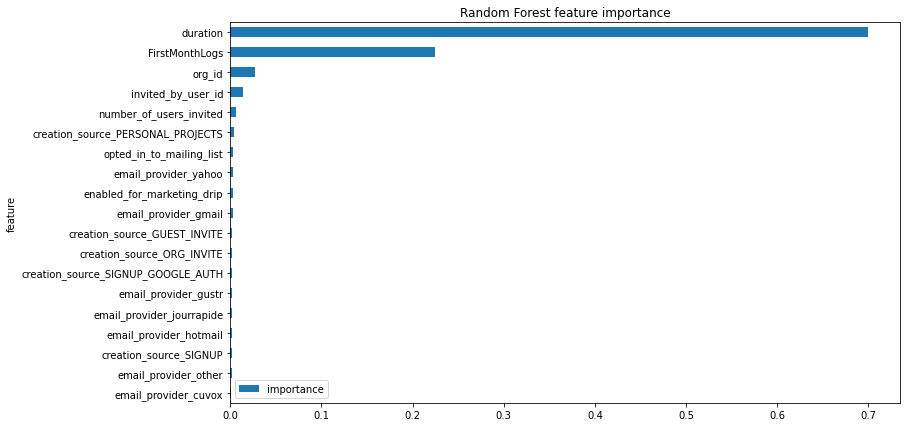

In [48]:
feat_imp = pd.DataFrame({'importance':model_rf.feature_importances_})    
feat_imp['feature'] = Xtrain.columns
#feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)#[-10:]
_ = feat_imp.plot.barh(title = 'Random Forest feature importance', figsize = (12,7))



Duration "days since the registeration of the account till last login" seems to be the most indicative, 
as is expected for adopted users to use the product longer. we can also predict the adopted users by the number of logs in their first month. Other factors with littel importance ar ethe organization and if sb invited them or they started with no invitation.

In [49]:
# calculating the values to calcuate precision_recall curve
precision, recall, thresholds = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])

middle_point = np.argmin(np.abs(thresholds - .5))
plt.plot(precision[middle_point], recall[middle_point], 'ro', fillstyle = 'none', markersize = 10, mew = 2,
         label = 'Default Prediction Threshold')
plt.plot(precision, recall, label = "Precision Recall Curve")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title("Precision Recall Curve for Adopted Users Class")
plt.legend()
plt.grid()



NameError: name 'precision_recall_curve' is not defined